# Da best heart disease classifier in town
- 13516083 / Abram Perdanaputra
- 13516090 / Timothy Thamrin Andrew Hamonangan Sihombing
- 13516093 / Muhammad Farhan
- 13516153 / Dimas Aditia Pratikto
- 13516155 / Restu Wahyu Kartiko

In [2]:
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing
from sklearn.feature_selection import RFE

import matplotlib.pyplot as plt
import numpy as np
import copy
import numbers

%matplotlib inline

#### Functions

In [3]:
# learning curve function

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

## Read dataset

Now we're going to read the `tubes2_HeartDisease_train` and `tubes2_HeartDisease_test`

In [4]:
def fix_data(data):
    """Convert dataframe to appropriate types"""
    for x in range(1,5):
        data.loc[data['Column3'] == x, 'Column3'] = str(x)

    num_col = [4, 5, 6, 8, 9, 10, 12]
    
    for col in num_col:
        col_name = 'Column'+str(col)
        data[col_name] = pd.to_numeric(data[col_name], errors='coerce')
    
    return data

def show_data(df, columns):
    data = copy.deepcopy(df)
    data.columns = columns
    
    return data

In [5]:
# data columns and read data from files

heart_disease = {}
heart_disease['columns_detail'] = [
    'Age', 
    'Sex', 
    'Pain type', 
    'Blood pressure', 
    'Serum cholesterol', 
    'Fasting blood sugar > 120mg/dl', 
    'Resting ECG', 
    'Max heart rate achieved', 
    'exercise induced agina', 
    'ST depression induced by exercise relative to rest', 
    'Peak exercise ST segment', 
    'Number of major vessels colored by flourosopy', 
    'Thal', 
    'Diagnosis'
]
heart_disease['train'] = pd.read_csv('../data/tubes2_HeartDisease_train.csv')
heart_disease['test'] = pd.read_csv('../data/tubes2_HeartDisease_test.csv')

In [6]:
heart_disease['train'] = fix_data(heart_disease['train'])
show_data(heart_disease['train'], heart_disease['columns_detail']).head()

,Age,Sex,Pain type,Blood pressure,Serum cholesterol,Fasting blood sugar > 120mg/dl,Resting ECG,Max heart rate achieved,exercise induced agina,ST depression induced by exercise relative to rest,Peak exercise ST segment,Number of major vessels colored by flourosopy,Thal,Diagnosis
0,54,1,4,125.0,216.0,0.0,0,140.0,0.0,0.0,?,NaN,?,1
1,55,1,4,158.0,217.0,0.0,0,110.0,1.0,2.5,2,NaN,?,1
2,54,0,3,135.0,304.0,1.0,0,170.0,0.0,0.0,1,0.0,3,0
3,48,0,3,120.0,195.0,0.0,0,125.0,0.0,0.0,?,NaN,?,0
4,50,1,4,120.0,0.0,0.0,1,156.0,1.0,0.0,1,NaN,6,3


## Data preprocessing

In [7]:
# Helpers
def preprocess_data(data):
    df = copy.deepcopy(data)
    
    # remove infinity and null
    df = df.replace([np.inf, -np.inf], np.nan)
    
#     for i, row in df.iterrows():
#         if row['Column11'] == '?':
#             df.loc[i, 'Column11'] = np.random.choice(['1', '2', '3'], \
#                                                size=1,\
#                                                p=[0.5570599613152805, 0.3404255319148936, 0.10251450676982592])[0]
    
    # dropping bad columns
    df = df.drop(['Column12', 'Column13'], axis=1)
    
    # dropping null values
    null_array = []
    for i, row in df.iterrows():
        if check_null(row) > 3:
            null_array.append(i)
            
    null_array.reverse()
    for i in null_array:
        df = df.drop(df.index[i])

    # remove outliers
    
    # fill null and nan with median
    df.loc[data['Column4'].isnull(), 'Column4'] = data['Column4'].median()
    df.loc[data['Column5'].isnull(), 'Column5'] = data['Column5'].median()
    df.loc[data['Column6'].isnull(), 'Column6'] = data['Column6'].median()
    df.loc[data['Column8'].isnull(), 'Column8'] = data['Column8'].median()
    df.loc[data['Column9'].isnull(), 'Column9'] = data['Column9'].median()
    df.loc[data['Column10'].isnull(), 'Column10'] = data['Column10'].median()
    
    df.loc[np.isnan(data['Column4']), 'Column4'] = data['Column4'].median()
    df.loc[np.isnan(data['Column5']), 'Column5'] = data['Column5'].median()
    df.loc[np.isnan(data['Column6']), 'Column6'] = data['Column6'].median()
    df.loc[np.isnan(data['Column8']), 'Column8'] = data['Column8'].median()
    df.loc[np.isnan(data['Column9']), 'Column9'] = data['Column9'].median()
    df.loc[np.isnan(data['Column10']), 'Column10'] = data['Column10'].median()
    
    df.loc[data['Column7'] == '?', 'Column7'] = '0'
    df.loc[data['Column11'] == '?', 'Column11'] = '1'
    
    df = pd.get_dummies(df)
    
    return df

def check_null(row):
    sum = 0
    for column in row:
        if isinstance(column, numbers.Number) and np.isnan(column):
            sum += 1
        if not(isinstance(column, numbers.Number)) and column == '?':
            sum += 1
        if column == None:
            sum += 1
    return sum

def check_outlier(row):
    outlier = False
    for column in row:
        if isinstance(column, numbers.Number) and np.isnan(column):
            sum += 1
        if not(isinstance(column, numbers.Number)) and column == '?':
            sum += 1
    return sum

In [8]:
df = preprocess_data(heart_disease['train'])

In [9]:
df.columns

Index([u'Column1', u'Column2', u'Column4', u'Column5', u'Column6', u'Column8',
       u'Column9', u'Column10', u'Column14', u'Column3_1', u'Column3_2',
       u'Column3_3', u'Column3_4', u'Column7_0', u'Column7_1', u'Column7_2',
       u'Column11_1', u'Column11_2', u'Column11_3'],
      dtype='object')

#### Data Distribution on Target

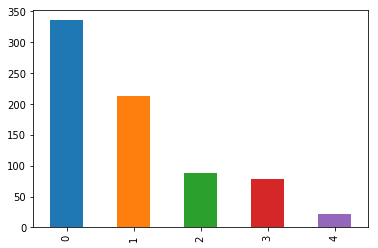

In [10]:
df['Column14'].value_counts().plot.bar()

## Experiment

In [11]:
cv = 5

### Decision Tree (ID3)

In [12]:
rand = 5

#### F1 Score

In [13]:
id3 = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=8
                             , max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=16, min_samples_split=16,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

# train
X_train, X_test, y_train, y_test = train_test_split(df.drop('Column14', axis=1), df.Column14,test_size=0.2)
id3.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=16,
            min_samples_split=16, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [14]:
# scores
id3_f1_scores = cross_val_score(id3, df.loc[:, df.columns != 'Column14']\
                , df['Column14'], cv=cv, scoring='f1_micro')
id3_accuracy_scores = cross_val_score(id3, df.loc[:, df.columns != 'Column14']\
                , df['Column14'], cv=cv, scoring='accuracy')
print("F1 Score: {:.4f} +- {:.4f}".format(id3_f1_scores.mean(), id3_f1_scores.std()))
print("Accuracy Score: {:.4f} +- {:.4f}".format(id3_accuracy_scores.mean(), id3_accuracy_scores.std()))
print("Test Score: {:.4f}".format(id3.score(X_test, y_test)))

F1 Score: 0.5891 +- 0.0148
Accuracy Score: 0.5891 +- 0.0148
Test Score: 0.5238


In [15]:
poly=PolynomialFeatures(5)
poly_x = poly.fit_transform(df.drop('Column14', axis=1))

parameters = {'max_depth':[3,6,9,12,15], 'min_samples_split':[2,4,8,16], 'min_samples_leaf':[1,2,4,8,16], 'max_features':[2,4,8,10]}
grid_search = GridSearchCV(id3, parameters, cv=5)
grid_search.fit(X_train,y_train)


print(id3.score(X_test,y_test))
print(grid_search.score(X_test,y_test))

0.5238095238095238
0.5238095238095238


In [16]:
grid_search.best_params_

{'max_depth': 3,
 'max_features': 10,
 'min_samples_leaf': 16,
 'min_samples_split': 2}

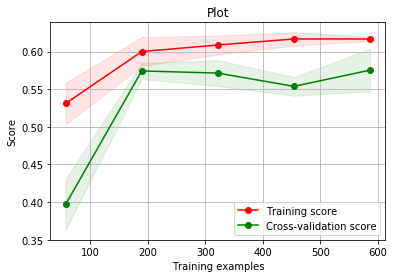

In [17]:
plot_learning_curve(id3, "Plot", df.drop("Column14",axis=1), df['Column14'])

In [18]:
print(classification_report(id3.predict(X_test),y_test))

             precision    recall  f1-score   support

          0       0.86      0.58      0.70        96
          1       0.40      0.54      0.46        37
          2       0.07      0.09      0.08        11
          3       0.00      0.00      0.00         3
          4       0.00      0.00      0.00         0

avg / total       0.67      0.52      0.58       147



/home/restukartiko/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [19]:
id3.feature_importances_

array([0.11023072, 0.        , 0.00603577, 0.14816933, 0.        ,
       0.05199567, 0.41664138, 0.01349452, 0.        , 0.        ,
       0.        , 0.0887546 , 0.00430238, 0.        , 0.0160559 ,
       0.08515363, 0.02200782, 0.03715828])

In [20]:
df.describe()

,Column1,Column2,Column4,Column5,Column6,Column8,Column9,Column10,Column14,Column3_1,Column3_2,Column3_3,Column3_4,Column7_0,Column7_1,Column7_2,Column11_1,Column11_2,Column11_3
count,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000,735.000000
mean,53.187755,0.767347,132.345578,202.380952,0.127891,138.361905,0.390476,3.917415,0.961905,0.047619,0.190476,0.213605,0.548299,0.616327,0.170068,0.212245,0.536054,0.391837,0.072109
std,9.446687,0.422811,19.094995,107.908058,0.334196,26.085265,0.488189,7.766025,1.121340,0.213104,0.392944,0.410130,0.498001,0.486611,0.375948,0.409176,0.499038,0.488493,0.258844
min,28.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,1.000000,120.000000,181.000000,0.000000,120.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,1.000000,130.000000,225.000000,0.000000,140.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,60.000000,1.000000,140.000000,269.000000,0.000000,159.000000,1.000000,2.700000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,77.000000,1.000000,200.000000,529.000000,1.000000,202.000000,1.000000,62.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
df.dtypes

Column1         int64
Column2         int64
Column4       float64
Column5       float64
Column6       float64
Column8       float64
Column9       float64
Column10      float64
Column14        int64
Column3_1       uint8
Column3_2       uint8
Column3_3       uint8
Column3_4       uint8
Column7_0       uint8
Column7_1       uint8
Column7_2       uint8
Column11_1      uint8
Column11_2      uint8
Column11_3      uint8
dtype: object

In [33]:
df.iloc[12]

Column1        61.0
Column2         1.0
Column4       142.0
Column5       200.0
Column6         1.0
Column8       100.0
Column9         0.0
Column10        1.5
Column14        3.0
Column3_1       1.0
Column3_2       0.0
Column3_3       0.0
Column3_4       0.0
Column7_0       0.0
Column7_1       1.0
Column7_2       0.0
Column11_1      0.0
Column11_2      0.0
Column11_3      1.0
Name: 12, dtype: float64

In [34]:
test = [61, 1, 142, 200, 1, 100, 0, 1.5, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
len(test)
test = [61.0, 1.0, 142.0, 200.0, 1.0, 100.0, 0.0, 1.5, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


18

In [35]:
id3.predict([test])[0]

0